This is a short tutorial intended to show the workings of SBI++.

Photometry of a galaxy from the validation set is used as an example to illustrate the performance of SBI++ in recovering redshift, and other key stellar population metrics in the prescence of out-of-distribution measurement errors and missing data.

Running this script requires
* the `sbi` Python package: [https://github.com/sbi-dev/sbi](https://github.com/sbi-dev/sbi)
* a trained model

Here we use the trained model from [Wang+23b](https://ui.adsabs.harvard.edu/abs/2023ApJ...952L..10W/abstract). The data files can be obtained from [here](https://drive.google.com/drive/folders/1jzV32r_KuTElgR74rwF4doCfzBf_RH2u?usp=share_link).

In [1]:
import os, sys, time, signal, warnings
# recommend running the full script without the line below first
# if an error is threw, then uncomment this line
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
from numpy.random import normal, uniform
from scipy.interpolate import interp1d

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils as Ut
from sbi import inference as Inference

# plot
import corner
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# all the functions implementing SBI++ are contained in `sbi_pp.py`
import sbi_pp

# Setup

In [2]:
run_params = {'nmc' : 50,           # number of MC samples
              'nposterior' : 50,    # number of posterior samples per MC drawn
              'np_baseline' : 500,  # number of posterior samples used in baseline SBI
              'ini_chi2' : 5,       # chi^2 cut usedi in the nearest neighbor search
              'max_chi2' : 500,     # the maximum chi^2 to reach in case we Incremently increase the chi^2 
                                    # in the case of insufficient neighbors
              'noisy_sig' : 3,      # deviation from the noise model, above which the measuremnt is taked as OOD
              'tmax_per_obj' : 120, # max time spent on one object / mc sample in secs
              'tmax_all' : 60,      # max time spent on all mc samples in mins
              'outdir' : 'output',  # output directory
              'verbose' : True,
              }

sbi_params = {'anpe_fname' : 'data/anpe_i20.pt',    # trained sbi model
              'train_fname' : 'data/train.i20.npz', # training set
              'test_fname' : 'data/test.i20.npz',   # testing set
              'noise_fname' : 'data/toy_noise_xy.i20.txt', # toy model used in training
                                                    # this files contains the median and the 1 sigma values
                                                    # of uncertainties in magnitude bins
              'nhidden' : 500, # architecture of the trained density estimator
              'nblocks' : 15,  # architecture of the trained density estimator
              }

## Reconstruct the trained SBI model from the pickle file

Refer to `sbi_train.py` for training a model

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# training set
data = np.load(sbi_params['train_fname'])
x_train = data['x'] # physical parameters
y_train = data['y'] # fluxes & uncertainties

# we will only need the lower & upper limits to be passed to sbi as "priors"
# here we simply read in the bounds from the training set
prior_low   = sbi_pp.prior_from_train('ll', x_train=x_train)
prior_high  = sbi_pp.prior_from_train('ul', x_train=x_train)
lower_bounds = torch.tensor(prior_low).to(device)
upper_bounds = torch.tensor(prior_high).to(device)
prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=device)

# density estimater
anpe = Inference.SNPE(prior=prior,
                      density_estimator=Ut.posterior_nn('maf', hidden_features=sbi_params['nhidden'], 
                                                        num_transforms=sbi_params['nblocks']),
                      device=device)
x_tensor = torch.as_tensor(x_train.astype(np.float32)).to(device)
y_tensor = torch.as_tensor(y_train.astype(np.float32)).to(device)
anpe.append_simulations(x_tensor, y_tensor)
p_x_y_estimator = anpe._build_neural_net(x_tensor, y_tensor)
p_x_y_estimator.load_state_dict(torch.load(sbi_params['anpe_fname'], map_location=torch.device(device)))
anpe._x_shape = Ut.x_shape_from_simulation(y_tensor)
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

# toy noise model
# note that this is only for illustrative purpose
# in practice, one'd have different medians and sigmas for the noise distributions,
# as well as a magnitude dependence.
toy_noise_x, toy_noise_y = np.loadtxt(sbi_params['noise_fname'], dtype=float, unpack=True)
meds_sigs = interp1d(toy_noise_x, toy_noise_y, kind='slinear', fill_value='extrapolate')
stds_sigs = interp1d(toy_noise_x, toy_noise_y, kind='slinear', fill_value='extrapolate')

# prepare to pass the reconstructed model to sbi_pp
sbi_params['y_train'] = y_train
sbi_params['hatp_x_y'] = hatp_x_y
sbi_params['toynoise_meds_sigs'] = meds_sigs
sbi_params['toynoise_stds_sigs'] = stds_sigs

# Running SBI++

We will try two methods:
* `sbi_pp.sbi_baseline()`: naively passing the photometry with out-of-distribution (OOD) measurement errors to the standard SBI. This will give wrong results. Note that this standard sbi does not allow missing data.
* `sbi_pp.sbi_pp()`: using SBI++ to deal with OOD measurement errors and missing bands.

In [4]:
np.random.seed(100) # make results reproducible

# a testing object of which the noises are OOD
obs = {}
obs['mags'] = np.array([27.88466754, 27.58003885, 27.21824627, 26.1618275 , 25.91341299,
                        25.90338989, 25.78924643, 25.89527949, 25.61875327, 25.21242166,
                        25.33969277, 25.51552593])
obs['mags_unc'] = np.array([1.7328788, 0.384539, 0.4797275 , 0.3101156, 0.03950926,
                            0.03477288, 0.0262702 , 0.0786114 , 0.2376355, 0.2016618,
                            0.01374542, 0.2756909])
obs['truths'] = np.array([ 1.39862487,  8.87680061, -0.13437992, -0.09674892, -0.62982116,
                           0.13844066,  0.14697821,  0.81193123,  4.52425247,  0.48590813,
                           0.16778978,  0.67088855, -3.21370136,  2.08441859, -1.04739414,
                           3.47574456,  4.6010982 , -2.45798957])

# run the stardard SBI
chain_ood, obs, flags = sbi_pp.sbi_baseline(obs=obs, run_params=run_params, sbi_params=sbi_params)

# make the photometry incomplete too
i_missing = 3
obs['mags'][i_missing] = np.nan
obs['mags_unc'][i_missing] = np.nan

# Run SBI++
chain, obs, flags = sbi_pp.sbi_pp(obs=obs, run_params=run_params, sbi_params=sbi_params)


baseline sbi
sbi missing and noisy bands
mc samples: 10
mc samples: 20
mc samples: 30
mc samples: 40
mc samples: 50


# Results

We see that SBI++ recovers the parameters, while improperly using the standard SBI produces significantly worse results due to out-of-distribution noises as expected.

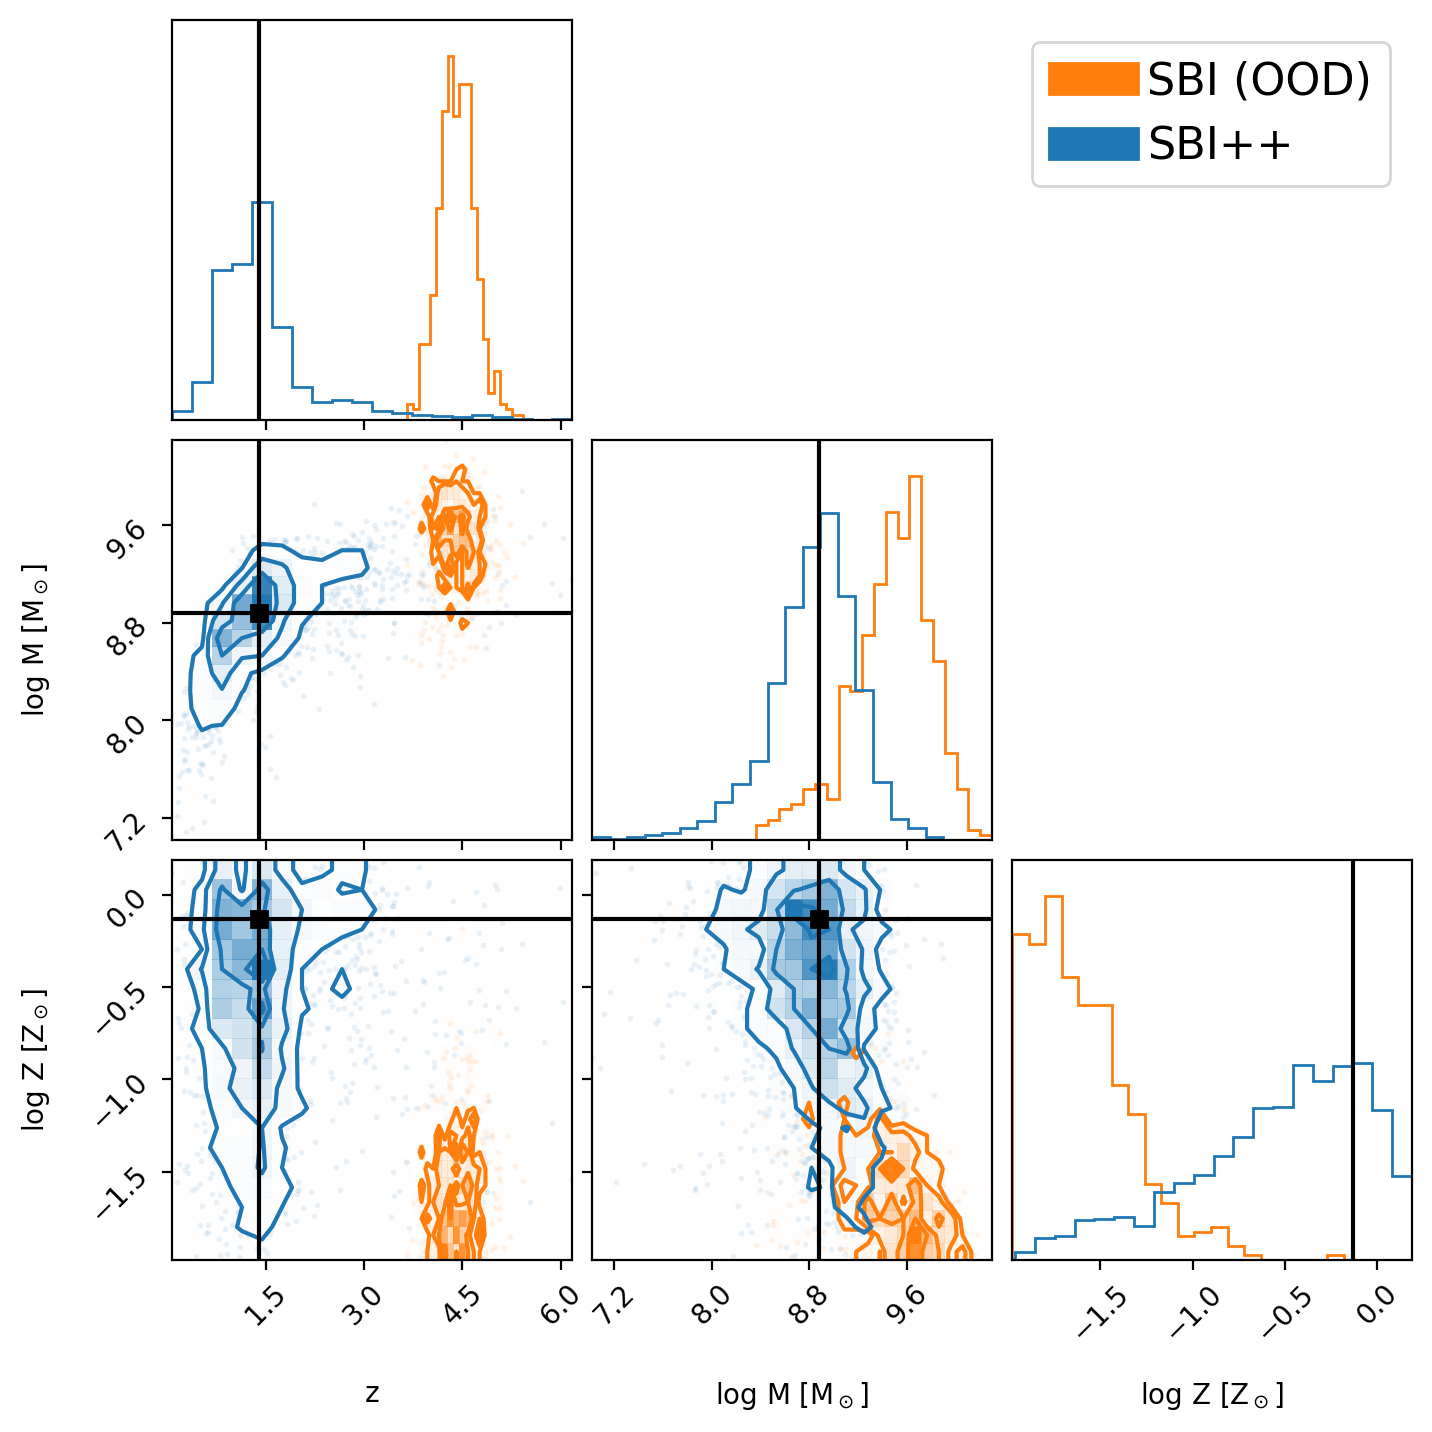

In [5]:
colors = ['C1', 'C0']
fig = corner.corner(chain_ood[:,:3], hist_kwargs={'density':True}, color=colors[0],
                    labels=['z', 'log M [M$_\odot$]', 'log Z [Z$_\odot$]'])
corner.corner(chain[:,:3], hist_kwargs={'density':True}, fig=fig, color=colors[1],
              truths=obs['truths'][:3], truth_color='k', )

ndim = int(np.sqrt(len(fig.axes)))
axes = np.array(fig.axes).reshape((ndim, ndim))
ax = axes[0, ndim-1]
ax.fill_between([], [], [], color=colors[0], label='SBI (OOD)')
ax.fill_between([], [], [], color=colors[1], label='SBI++')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=16)

plt.show()